In [1]:
import pandas as pd
import optuna
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import numpy as np
import pandas_ta as ta
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Nadam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
from keras.layers import Dropout, Dense, GRU, LSTM, Flatten
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore', category = pd.errors.PerformanceWarning)

In [3]:
# Pobieramy dane dotyczące BTC z yahoo
BTC = yf.download('BTC-USD', start = '2022-02-24', end = '2024-01-01')

BTC['Target'] = (BTC['Close'].diff() > 0).astype(int)

def add_lagged_features(data, column_name, n_days):
    for i in range(1, n_days + 1):
        lagged_column_name = f'{column_name}_{i}d_back'
        data[lagged_column_name] = data[column_name].shift(i)
    return data

BTC = add_lagged_features(BTC, 'Close', 30)
BTC = add_lagged_features(BTC, 'Open', 30)
BTC = add_lagged_features(BTC, 'High', 30)
BTC = add_lagged_features(BTC, 'Low', 30)

# df = pd.DataFrame()
# df = BTC.copy()
# print(BTC.head())
print(len(BTC))
print(BTC.shape)

[*********************100%%**********************]  1 of 1 completed

676
(676, 127)


In [4]:
BTC = BTC.drop('Adj Close', axis=1)
BTC = BTC.dropna().reset_index(drop = True)
# BTC

In [5]:
dataset = pd.DataFrame()
dataset = BTC[['Open', 'High', 'Low', 'Close', 'Volume', 'Target']].copy()
# dataset

In [6]:
n_steps_in = 20
output_features = 2

In [7]:
X_value = pd.DataFrame(dataset.iloc[:, :])
X_value = X_value.drop('Target', axis='columns')
# X_value

In [8]:
y_value = pd.DataFrame(dataset.Target)
y_value = to_categorical(y_value)
# y_value

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_value)
X_value = scaler.fit_transform(X_value)

In [10]:
def get_X_y(X_data, y_data):
    X = list()
    y = list()

    length = len(X_data)
    for i in range(0, length-n_steps_in, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        # y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, :]
        y_value = y_data[i + n_steps_in]
        if len(X_value) == n_steps_in and len(y_value) == output_features:
            X.append(X_value)
            y.append(y_value)

    return np.array(X), np.array(y)

In [11]:
def split_train_test(data):
    train_size = int(0.8 * len(X))
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [12]:
X, y = get_X_y(X_value, y_value)
print('X shape: ', X.shape)
print('y shape: ', y.shape)
train_features, test_features = split_train_test(X) 
train_target, test_target = split_train_test(y) 

print('Train features shape: ', train_features.shape)
print('Test features shape: ', test_features.shape)
print('Train features shape: ', train_target.shape)
print('Test features shape: ', test_target.shape)

X shape:  (626, 20, 5)
y shape:  (626, 2)
Train features shape:  (500, 20, 5)
Test features shape:  (126, 20, 5)
Train features shape:  (500, 2)
Test features shape:  (126, 2)


In [13]:
input_dim = train_features.shape[1]
input_feature_size = train_features.shape[2]
output_dim = train_target.shape[1]

In [14]:
N_EPOCH = 50
BATCH_SIZE = 64

def basic_LSTM(input_dim, output_dim, input_feature_size):
    model = Sequential()
    model.add(LSTM(units=63, return_sequences=True, activation='relu', input_shape=(input_dim, input_feature_size)))
    model.add(Dropout(0.2))
    model.add(LSTM(250, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim, activation='softmax'))

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    history = model.fit(train_features, train_target, epochs=N_EPOCH, 
                        validation_data=(test_features, test_target),
                        batch_size=BATCH_SIZE, verbose=2, shuffle=False)

    return model, history

In [15]:
model, history = basic_LSTM(input_dim, output_dim, input_feature_size)

C:\Users\48798\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
8/8 - 18s - 2s/step - accuracy: 0.5280 - loss: 0.6937 - val_accuracy: 0.4683 - val_loss: 0.7305
Epoch 2/50
8/8 - 2s - 241ms/step - accuracy: 0.5040 - loss: 0.6955 - val_accuracy: 0.4683 - val_loss: 0.7155
Epoch 3/50
8/8 - 2s - 222ms/step - accuracy: 0.5360 - loss: 0.6903 - val_accuracy: 0.4683 - val_loss: 0.7144
Epoch 4/50
8/8 - 2s - 210ms/step - accuracy: 0.5360 - loss: 0.6901 - val_accuracy: 0.4683 - val_loss: 0.7086
Epoch 5/50
8/8 - 3s - 343ms/step - accuracy: 0.5340 - loss: 0.6901 - val_accuracy: 0.4683 - val_loss: 0.7142
Epoch 6/50
8/8 - 2s - 244ms/step - accuracy: 0.5380 - loss: 0.6902 - val_accuracy: 0.4683 - val_loss: 0.7226
Epoch 7/50
8/8 - 2s - 232ms/step - accuracy: 0.5340 - loss: 0.6912 - val_accuracy: 0.4683 - val_loss: 0.7150
Epoch 8/50
8/8 - 2s - 223ms/step - accuracy: 0.5360 - loss: 0.6897 - val_accuracy: 0.4683 - val_loss: 0.7229
Epoch 9/50
8/8 - 2s - 301ms/step - accuracy: 0.5360 - loss: 0.6884 - val_accuracy: 0.4683 - val_loss: 0.7168
Epoch 10/50
8/8 - 1s 

In [16]:
# Ocena modelu na danych treningowych
train_performance = model.evaluate(train_features, train_target)
print('Train loss:', train_performance[0])
print('Train accuracy:', train_performance[1])

test_performance = model.evaluate(test_features, test_target)
print('Test loss:', test_performance[0])
print('Test accuracy:', test_performance[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5781 - loss: 0.6726
Train loss: 0.6785959601402283
Train accuracy: 0.5659999847412109
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4454 - loss: 0.7217
Test loss: 0.7417741417884827
Test accuracy: 0.4365079402923584


In [17]:
# Predykcja na zbiorze treningowym
train_predictions = model.predict(train_features)
train_predictions = np.argmax(train_predictions, axis = 1)
train_true = np.argmax(train_target, axis = 1)

# Obliczanie macierzy pomyłek
cm = confusion_matrix(train_true, train_predictions)
TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

print(TP)
print(TN)
print(FP)
print(FN)

# TPR, FPR, TNR, PPV, NPV
ACC = (TP + TN) / (TP + TN + FP + FN)
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print('Accuracy (ACC):', ACC)
print('True Positive Rate (TPR):', TPR)
print('False Positive Rate (FPR):', FPR)
print('True Negative Rate (TNR):', TNR)
print('Positive Predictive Value (PPV):', PPV)
print('Negative Predictive Value (NPV):', NPV)

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step
59
224
44
173
Accuracy (ACC): 0.566
True Positive Rate (TPR): 0.2543103448275862
False Positive Rate (FPR): 0.16417910447761194
True Negative Rate (TNR): 0.835820895522388
Positive Predictive Value (PPV): 0.5728155339805825
Negative Predictive Value (NPV): 0.5642317380352645


In [18]:
# Predykcja na zbiorze testowym
test_predictions = model.predict(test_features)
test_predictions = np.argmax(test_predictions, axis = 1)
test_true = np.argmax(test_target, axis = 1)

# Obliczanie macierzy pomyłek
cm = confusion_matrix(test_true, test_predictions)
TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

print(TP)
print(TN)
print(FP)
print(FN)

# TPR, FPR, TNR, PPV, NPV
ACC = (TP + TN) / (TP + TN + FP + FN)
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print('Accuracy (ACC):', ACC)
print('True Positive Rate (TPR):', TPR)
print('False Positive Rate (FPR):', FPR)
print('True Negative Rate (TNR):', TNR)
print('Positive Predictive Value (PPV):', PPV)
print('Negative Predictive Value (NPV):', NPV)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
25
30
29
42
Accuracy (ACC): 0.4365079365079365
True Positive Rate (TPR): 0.373134328358209
False Positive Rate (FPR): 0.4915254237288136
True Negative Rate (TNR): 0.5084745762711864
Positive Predictive Value (PPV): 0.46296296296296297
Negative Predictive Value (NPV): 0.4166666666666667


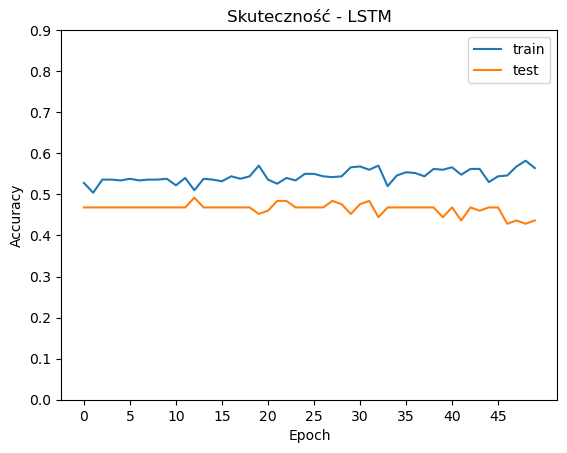

In [19]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="test")
plt.title("Skuteczność - LSTM")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, N_EPOCH, step=5))
plt.yticks(np.arange(0, 1, step=0.1))
plt.legend()
plt.show()

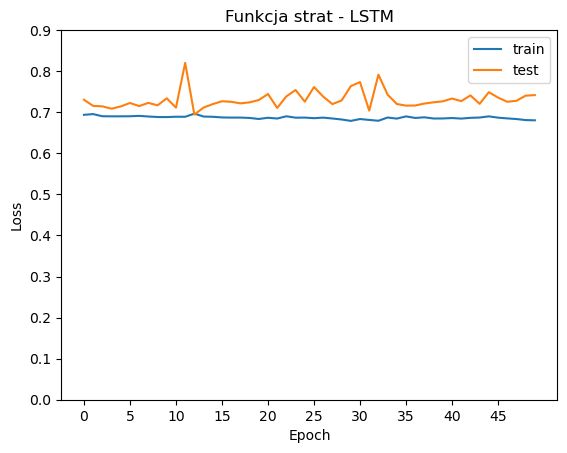

In [20]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.title("Funkcja strat - LSTM")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(np.arange(0, N_EPOCH, step=5))
plt.yticks(np.arange(0, 1, step=0.1))
plt.legend()
plt.show()